# Scheduling Parameters with [ReLax](https://github.com/nslyubaykin/relax) (TRPO step KL divergence)


For ReLAx & Mujoco installation see: https://github.com/nslyubaykin/relax/blob/master/README.md

Useful readings regarding TRPO:
    
    TRPO paper: https://arxiv.org/abs/1502.05477
    GAE paper: https://arxiv.org/abs/1506.02438
    TRPO description: https://spinningup.openai.com/en/latest/algorithms/trpo.html

!Note: For examining trained actor you may just load trained policies from \trained_models directory. To do that instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Trained policies, logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/trpo_schedule_kl

In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.actors import TRPO
from relax.rl.critics import GAE

from relax.schedules import *

from relax.zoo.policies import CategoricalMLP, NormalMLP
from relax.zoo.critics import VMLP

from relax.data.sampling import Sampler

from relax.gym.utils import visualize_actor

/home/nikita/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defining TRPO actor and GAE critic

In this example to demonstrate scheduling possibilities in ReLAx TRPO-GAE algorithm was used. For the brevity of this example detailed TRPO-GAE example was omitted. Use [this link](https://github.com/nslyubaykin/relax_trpo_example/blob/master/trpo_example.ipynb) to access TRPO-GAE tutorial.

# Create training and eval environments

In [16]:
env_name = 'LunarLander-v2'
env = gym.make(env_name)
eval_env = gym.make(env_name)
eval_env.seed(np.random.randint(100))

[70]

In [17]:
env.action_space

Discrete(4)

In [18]:
env.observation_space

Box(8,)

In [19]:
acs_dim = 4
obs_dim = 8

# Define `eps` schedule

TRPO uses Fisher Information Matrix in order to control learning step KL-divergence (`eps`). Such setting helps to improve performance comparing to VPG by avoiding unsafe updates.

We will now construct a non-trivial `eps` schedule for demonstration purposes only __(it may be very sub-optimal in terms of effective training)__ and then compare it to actually observed KL-divergence during the training phase.

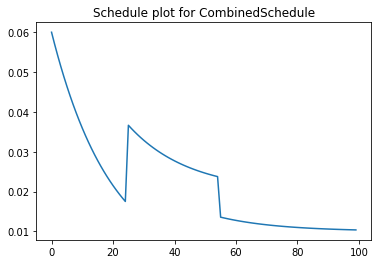

In [20]:
eps1 = PiecewiseSchedule({0.0: 25,
                          0.02: 30,
                          0.01: 40}, 0.01)
eps2 = ExponentialSchedule(gamma=0.95, start_value=0.06)
#eps_schedule = eps2
eps_schedule = CombinedSchedule(eps1, eps2, agg_func=np.sum)
eps_schedule.plot(100)

# Define TRPO actor:

In [21]:
actor = TRPO(
    policy_net=CategoricalMLP(obs_dim, acs_dim, 
                              nunits=64, nlayers=2),
    device=torch.device('cuda'),
    eps=eps_schedule # passing schedule instead of float
)

# Define GAE-$ \lambda $ critic:

In [22]:
critic = GAE(
    critic_net=VMLP(obs_dim, nlayers=2, nunits=64),
    device=torch.device('cuda'),
    learning_rate=1e-4,
    batch_size=4368,
    gamma=0.99,
    gae_lambda=0.95,
    n_target_updates=1, 
    n_steps_per_update=20
)

# Provide actor with critic:

In [23]:
actor.set_critic(critic)

# Wrap envs into Sampler:

In [24]:
sampler = Sampler(env=env)
eval_sampler = Sampler(env=eval_env)

# Run Training and Validation loop:

In [26]:
n_steps = 100
logdir = '/home/nikita/Desktop/RelaxExamples/TRPOScheduleKL/tensorboard_logs'
run_name = 'trpo_lander'
logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')
all_logs = []

for step in tqdm(range(n_steps)): 
    
    # sample training batch
    train_batch = sampler.sample(actor=actor,
                                 n_transitions=40000,
                                 max_path_length=None, 
                                 reset_when_not_done=False,
                                 train_sampling=True)
    
    # update critic
    critic_logs = critic.update(train_batch)
        
    # update actor
    actor_logs = actor.update(train_batch)
     
    # evaluating the policy
    eval_batch = eval_sampler.sample_n_episodes(actor=actor,
                                                n_episodes=5,
                                                max_path_length=None, 
                                                train_sampling=False)
    # Logging
    train_logs = train_batch.create_logs(prefix='train')
    eval_logs = eval_batch.create_logs(prefix='eval')
    
    logs = {**critic_logs,
            **actor_logs,
            **train_logs,
            **eval_logs}
    all_logs.append(logs)

    for key, value in logs.items():
        logger.add_scalar(key, value, step)
    
logger.flush()

100%|██████████| 100/100 [2:02:55<00:00, 73.75s/it] 


In [12]:
%load_ext tensorboard
%tensorboard --logdir /home/nikita/Desktop/RelaxExamples/TRPOScheduleKL/tensorboard_logs

# Plot Theoretical vs Actual KL-divergence

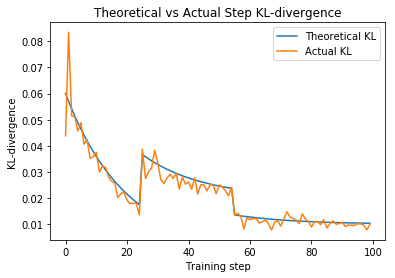

In [27]:
theoretical_kl = [actor.eps.value(t) for t in range(100)]
actual_kl = [l['TRPO_avg_step_kl_div'] for l in all_logs]

plt.plot(theoretical_kl, label='Theoretical KL')
plt.plot(actual_kl, label='Actual KL')
plt.legend()
plt.title(f'Theoretical vs Actual Step KL-divergence')
plt.xlabel('Training step')
plt.ylabel('KL-divergence')
plt.show()

# Save Models

In [28]:
actor.save_checkpoint('trained_models', 'trpo_actor')
critic.save_checkpoint('trained_models', 'gae_critic')

Saved checkpoints for TRPO...
models_state_dict global_step n_updates
Saved checkpoints for GAE...
models_state_dict global_step n_updates optimizer scheduler


/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


# Load Models

In [18]:
actor.load_checkpoint('trained_models', 'trpo_actor')
critic.load_checkpoint('trained_models', 'gae_critic')